In [1]:
from pyspark.ml.stat import Correlation
from pyspark.sql.functions import col, pow,isnan,when,count,avg,last
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder,PCA
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator,ClusteringEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.clustering import KMeans
from pyspark.ml.classification import LinearSVC
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.feature import MinMaxScaler
import pyspark.ml.tuning as tune
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import GBTClassifier
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import pyspark
import sys
from pyspark.sql import Window
from pyspark.sql import SparkSession
import pyspark.pandas as ps

In [2]:
print(pyspark.__version__)

3.2.1


In [3]:
spark = SparkSession.builder.master("local[*]").appName("Telco Customer Churn Prediction").getOrCreate()

In [4]:
df = spark.read.csv('train.csv',header=True,sep= ",",inferSchema=True)

In [5]:
df.columns

['customerID',
 'gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'tenure',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'MonthlyCharges',
 'TotalCharges',
 'Churn']

In [6]:
df.printSchema()

root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: integer (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: string (nullable = true)
 |-- Churn: string (nullable = true)



1. From this we can see that lot of features are in string type we might need to change it to numererical feature.

In [7]:
df.describe().toPandas()

,summary,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,count,7043,7043,7043,7043,7043,7043,7043,7043,7043,...,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043
1,mean,None,None,0.1621468124378816,None,None,32.37114865824223,None,None,None,...,None,None,None,None,None,None,None,64.76169246059922,2283.3004408418697,None
2,stddev,None,None,0.3686116056100135,None,None,24.559481023094442,None,None,None,...,None,None,None,None,None,None,None,30.090047097678482,2266.771361883145,None
3,min,0002-ORFBO,Female,0,No,No,0,No,No,DSL,...,No,No,No,No,Month-to-month,No,Bank transfer (automatic),18.25,,No
4,max,9995-HOTOH,Male,1,Yes,Yes,72,Yes,Yes,No,...,Yes,Yes,Yes,Yes,Two year,Yes,Mailed check,118.75,999.9,Yes


#### Checking whether the outcome variable is balanced or not?
1. In this case the outcome variable is imabalced

In [8]:
df.groupby("Churn").count().show()

+-----+-----+
|Churn|count|
+-----+-----+
|   No| 5174|
|  Yes| 1869|
+-----+-----+



#### Checking if there any missing values in this data set
1. There are no missing values in this dataset

In [9]:
df.select([count(when(isnan(c),c)).alias(c) for c in df.columns]).toPandas().head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Checking the unique values of every feature
1. We can see that most of the features are categorical features except Tenure, Cutomer ID, MonthlyCharges and TotalCharges
2. We can also notice that all the columns unique values are readable except for the PaymentMethod. We might need to change it

In [10]:
for i in df.columns:
    df.select(i).distinct().show()

+----------+
|customerID|
+----------+
|3668-QPYBK|
|6234-RAAPL|
|1894-IGFSG|
|6982-SSHFK|
|5859-HZYLF|
|6479-OAUSD|
|2592-YKDIF|
|6718-BDGHG|
|3195-TQDZX|
|4248-QPAVC|
|5668-MEISB|
|5802-ADBRC|
|2712-SYWAY|
|2011-TRQYE|
|7244-KXYZN|
|0953-LGOVU|
|3623-FQBOX|
|3692-JHONH|
|3528-HFRIQ|
|7661-CPURM|
+----------+
only showing top 20 rows

+------+
|gender|
+------+
|Female|
|  Male|
+------+

+-------------+
|SeniorCitizen|
+-------------+
|            1|
|            0|
+-------------+

+-------+
|Partner|
+-------+
|     No|
|    Yes|
+-------+

+----------+
|Dependents|
+----------+
|        No|
|       Yes|
+----------+

+------+
|tenure|
+------+
|    31|
|    65|
|    53|
|    34|
|    28|
|    27|
|    26|
|    44|
|    12|
|    22|
|    47|
|     1|
|    52|
|    13|
|    16|
|     6|
|     3|
|    20|
|    40|
|    57|
+------+
only showing top 20 rows

+------------+
|PhoneService|
+------------+
|          No|
|         Yes|
+------------+

+----------------+
|   MultipleLines|

#### Meaning of each and Every features

https://towardsdatascience.com/machine-learning-case-study-telco-customer-churn-prediction-bc4be03c9e1d#:~:text=Telcos%20apply%20machine%20learning%20models,the%20domain%20of%20supervised%20learning.

##### Output variable 

1. Churn — Whether the customer churned or not (Yes or No)

##### Customer services booked

1. PhoneService — Whether the customer has a phone service (Yes, No)
2. MultipleLines — Whether the customer has multiple lines (Yes, No, No phone service)
3. InternetService — Customer’s internet service provider (DSL, Fiber optic, No)
4. OnlineSecurity — Whether the customer has online security (Yes, No, No internet service)
5. OnlineBackup — Whether the customer has online backup (Yes, No, No internet service)
6. DeviceProtection — Whether the customer has device protection (Yes, No, No internet service)
7. TechSupport — Whether the customer has tech support (Yes, No, No internet service)
8. StreamingTV — Whether the customer has streaming TV (Yes, No, No internet service)
9. StreamingMovies — Whether the customer has streaming movies (Yes, No, No internet service)

##### Customer account information

1. Tenure — Number of months the customer has stayed with the company
2. Contract — The contract term of the customer (Month-to-month, One year, Two year)
3. PaperlessBilling — Whether the customer has paperless billing (Yes, No)
4. PaymentMethod — The customer’s payment method (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic))
5. MonthlyCharges — The amount charged to the customer monthly
6. TotalCharges — The total amount charged to the customer

##### Customers demographic info

1. customerID — Customer ID
2. Gender — Whether the customer is a male or a female
3. SeniorCitizen — Whether the customer is a senior citizen or not (1, 0)
4. Partner — Whether the customer has a partner or not (Yes, No)
5. Dependents — Whether the customer has dependents or not (Yes, No)

### Data Preprocessing

In [11]:
df.printSchema()

root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: integer (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: string (nullable = true)
 |-- Churn: string (nullable = true)



In [12]:
## Changing the data types of interger to floats.
data = df.withColumn("SeniorCitizen",col("SeniorCitizen").cast('double')).withColumn("tenure",col("tenure").cast('double'))
data = df.withColumn("TotalCharges",col("TotalCharges").cast('double'))

In [13]:
data.printSchema()

root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: integer (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: double (nullable = true)
 |-- Churn: string (nullable = true)



#### Data exploration

In [14]:
new_data = data.toPandas()

In [15]:
new_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [16]:
new_data.dtypes

customerID           object
gender               object
SeniorCitizen         int32
Partner              object
Dependents           object
tenure                int32
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

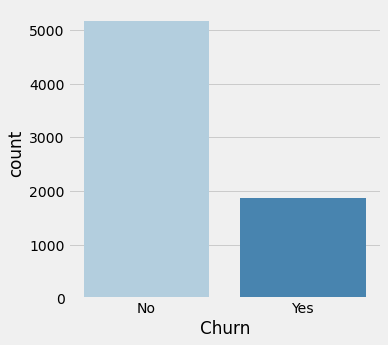

In [17]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(5, 5))
ax = sns.countplot(x=new_data['Churn'], palette="Blues", linewidth=1)
plt.show()

In [18]:
### Box plots 

plots = {1 : [111], 2: [121, 122], 3: [131, 132, 133], 4: [221, 222, 223, 224], 5: [231, 232, 233, 234, 235],\
         6: [231, 232, 233, 234, 235, 236]}

def boxplot(x, y, df):
    
    rows = int(str(plots[len(y)][0])[0])
    columns = int(str(plots[len(y)][0])[1])
    plt.figure(figsize=(7*columns, 7*rows))
    
    for i, j in enumerate(y):
        plt.subplot(plots[len(y)][i])
        ax = sns.boxplot(x=x, y=j, data=new_data[[x, j]], palette="Blues", linewidth=1)
        ax.set_title(j)
        
    return plt.show()

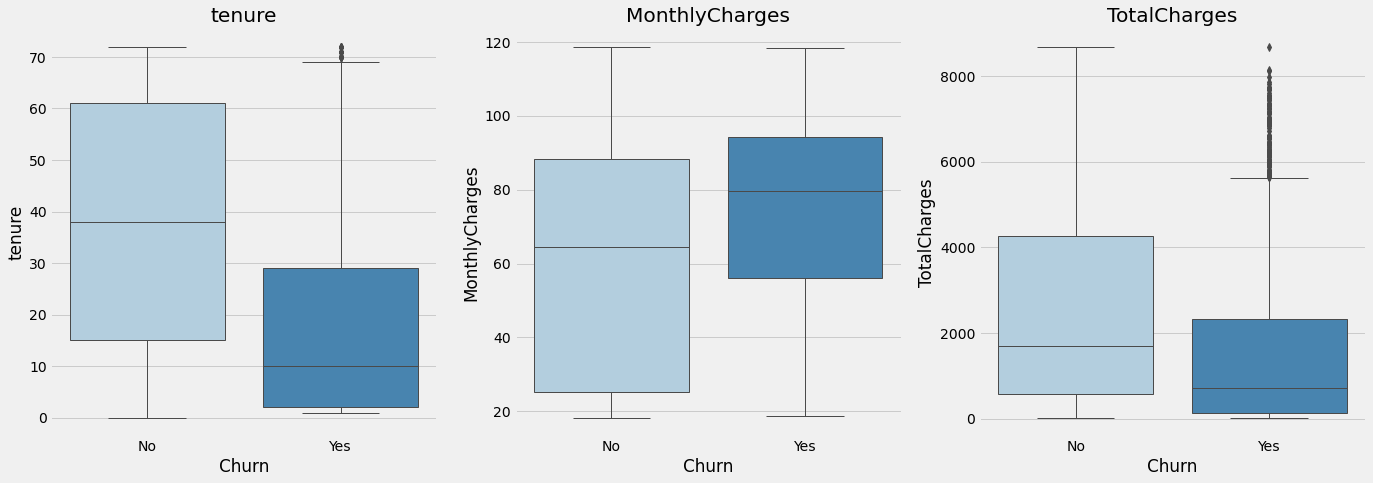

In [19]:
boxplot("Churn", ["tenure", "MonthlyCharges", "TotalCharges"], new_data)

In [20]:
# Create a function to generate countplots:
def countplot(x, y, new_data):
    
    rows = int(str(plots[len(y)][0])[0])
    columns = int(str(plots[len(y)][0])[1])
    
    plt.figure(figsize=(7*columns, 7*rows))
    
    for i, j in enumerate(y):
        plt.subplot(plots[len(y)][i])
        ax = sns.countplot(x=j, hue=x, data=new_data, palette='Blues', alpha=0.8, linewidth=0.4, edgecolor='black')
        ax.set_title(j)
        
    return plt.show()

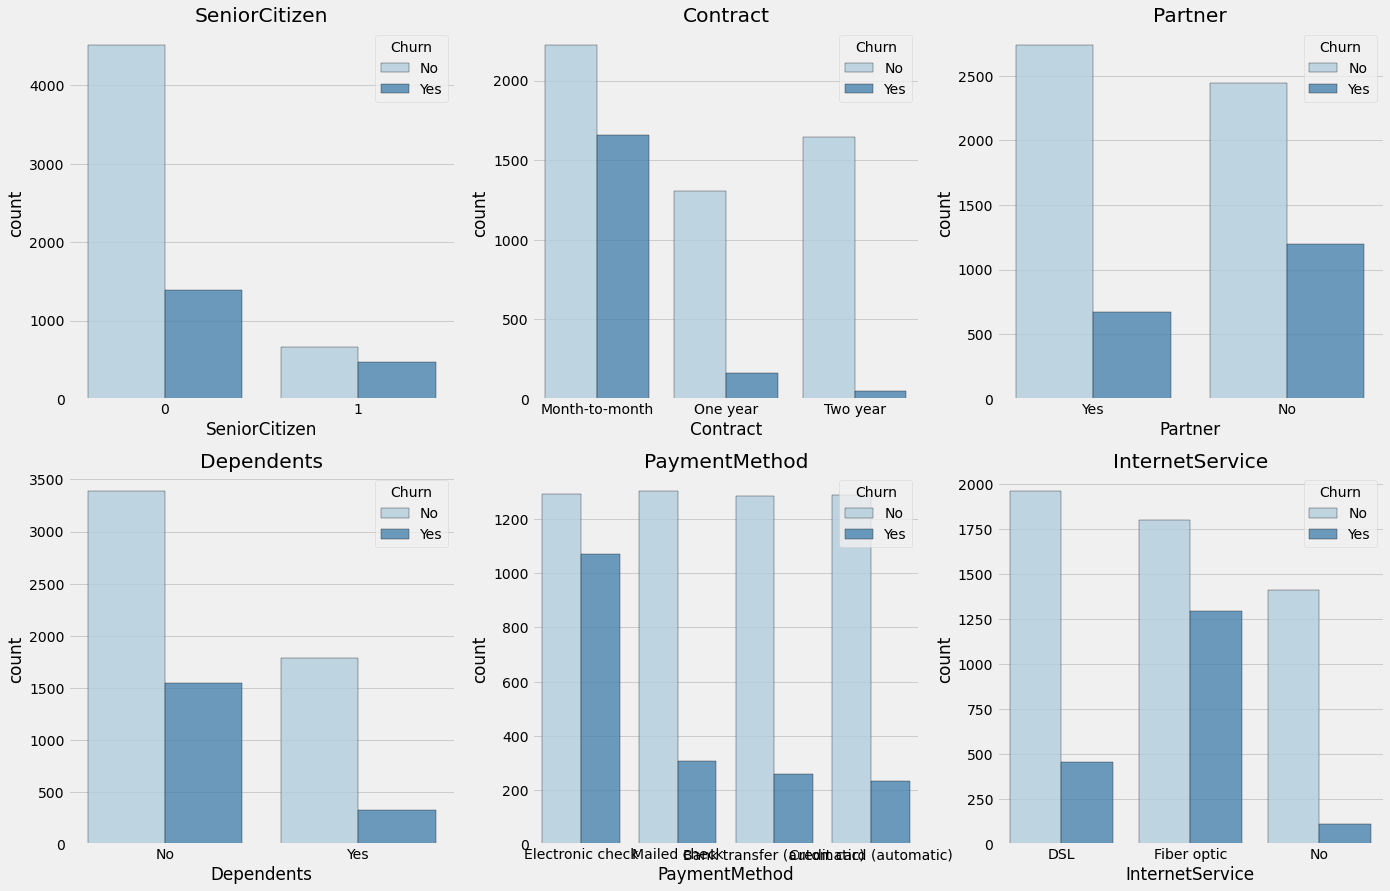

In [21]:
countplot("Churn", ['SeniorCitizen', 'Contract', 'Partner', 'Dependents', 'PaymentMethod', 'InternetService'], new_data)

#### Check for Outliers in Numerical Features

In [22]:
# Check of outliers by applying the IQR method checking if values are way outside the IQR borders.
numerical_features = ["tenure", "MonthlyCharges", "TotalCharges"]
df_num = new_data[numerical_features]
df_num.describe()

Q1 = df_num.quantile(0.25)
Q3 = df_num.quantile(0.75)
IQR = Q3 - Q1
IQR
((df_num < (Q1 - 1.5 * IQR)) | (df_num > (Q3 + 1.5 * IQR))).any()

tenure            False
MonthlyCharges    False
TotalCharges      False
dtype: bool

In [23]:
new_data.isna().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [24]:
new_data = new_data.dropna()

In [25]:
new_data.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

### Feature Engineering 

Based on the data types and the values, following actions are defined to preprocess/engineer the features for machine readibility and further analysis:

**Columns removed**
- customerID: not relevant

**No action**
- SeniorCitizen

**Label encoding**
The following features are categorical and each take on 2 values (mostly yes/no) - therefore are transformed to binary integers
- gender
- Partner
- Dependents
- Churn
- PhoneService
- PaperlessBilling

**One-Hot Encoding**
The following features are categorical, yet not ordinal (no ranking) but take on more than 2 values. For each value, a new variable is created with a binary integer indicating if the value occured in a data entry or not (1 or 0). 
- MultipleLines
- InternetService
- OnlineSecurity
- OnlineBackup
- DeviceProtection
- TechSupport
- StreamingTV
- StreamingMovies
- Contract
- PaymentMethod

**Min-Max Scaling**
Values of numerical features are rescaled between a range of 0 and 1. Min-max scaler is the standard approach for scaling. For normally distributed features standard scaler could be used, which scales values around a mean of 0 and a standard deviation of 1. For simplicity we use min-max scaler for all numerical features.
- tenure
- TotalCharges
- MonthlyCharges

In [26]:
new_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [27]:
new_data.dtypes

customerID           object
gender               object
SeniorCitizen         int32
Partner              object
Dependents           object
tenure                int32
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

In [28]:
# removing the columns customer id because it irrelevant
new_data1 = new_data.drop(columns='customerID')

In [29]:
new_data1.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [30]:
# Generate new feature "Number_AdditionalServices" by summing up the number of add-on services consumed.
columns = ['OnlineSecurity', 'DeviceProtection', 'StreamingMovies', 'TechSupport', 'StreamingTV', 'OnlineBackup']
new_data1['Number_AdditionalServices'] = (new_data1[columns] == 'Yes').sum(axis=1)

In [31]:
new_data1.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Number_AdditionalServices
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,...,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,1
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,...,No,No,No,One year,No,Mailed check,56.95,1889.50,No,2
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,...,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,2
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,...,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,3
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,...,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,0


In [32]:
new_data1.dtypes

gender                        object
SeniorCitizen                  int32
Partner                       object
Dependents                    object
tenure                         int32
PhoneService                  object
MultipleLines                 object
InternetService               object
OnlineSecurity                object
OnlineBackup                  object
DeviceProtection              object
TechSupport                   object
StreamingTV                   object
StreamingMovies               object
Contract                      object
PaperlessBilling              object
PaymentMethod                 object
MonthlyCharges               float64
TotalCharges                 float64
Churn                         object
Number_AdditionalServices      int64
dtype: object

In [33]:
new_data1 = new_data1.astype({"Number_AdditionalServices": int}, errors='raise') 

In [34]:
new_data1.dtypes

gender                        object
SeniorCitizen                  int32
Partner                       object
Dependents                    object
tenure                         int32
PhoneService                  object
MultipleLines                 object
InternetService               object
OnlineSecurity                object
OnlineBackup                  object
DeviceProtection              object
TechSupport                   object
StreamingTV                   object
StreamingMovies               object
Contract                      object
PaperlessBilling              object
PaymentMethod                 object
MonthlyCharges               float64
TotalCharges                 float64
Churn                         object
Number_AdditionalServices      int32
dtype: object

In [35]:
new_data1.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Number_AdditionalServices
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,...,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,1
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,...,No,No,No,One year,No,Mailed check,56.95,1889.50,No,2
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,...,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,2
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,...,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,3
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,...,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,0


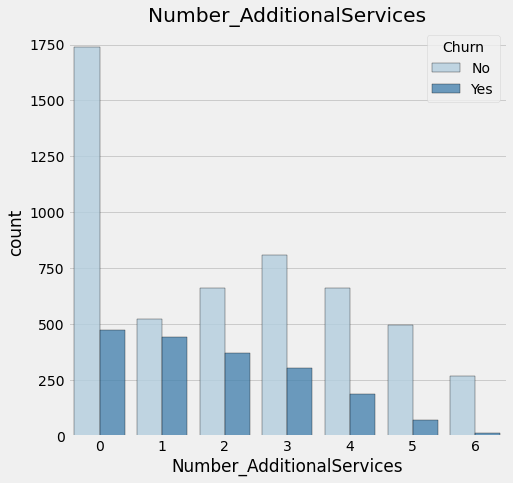

In [36]:
countplot('Churn', ['Number_AdditionalServices'], new_data1)

In [37]:
new_data1.to_csv("new_data_sampletry.csv",index=False)

In [38]:
new_data2 = spark.read.csv('new_data_sampletry.csv',header=True,sep= ",",inferSchema=True)

In [39]:
new_data2.printSchema()

root
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: integer (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: double (nullable = true)
 |-- Churn: string (nullable = true)
 |-- Number_AdditionalServices: integer (nullable = true)



In [40]:
cols = ["SeniorCitizen","tenure","MonthlyCharges","TotalCharges","Number_AdditionalServices"]
indexers = [StringIndexer(inputCol = c, outputCol = c+"_index").fit(new_data2) for c in list(set(new_data2.columns)-set(cols))]

pipeline = Pipeline(stages=indexers)

df1 = pipeline.fit(new_data2).transform(new_data2)

In [41]:
df1.toPandas()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,PhoneService_index,OnlineSecurity_index,Dependents_index,StreamingTV_index,TechSupport_index,DeviceProtection_index,gender_index,Contract_index,PaymentMethod_index,StreamingMovies_index
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2.0,1.0,0.0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,...,1.0,1.0,0.0,0.0,1.0,1.0,0.0,2.0,2.0,0.0
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7027,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,...,0.0,1.0,1.0,1.0,1.0,1.0,0.0,2.0,1.0,1.0
7028,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,...,0.0,0.0,1.0,1.0,0.0,1.0,1.0,2.0,3.0,1.0
7029,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,...,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
7030,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [42]:
df1.dtypes

[('gender', 'string'),
 ('SeniorCitizen', 'int'),
 ('Partner', 'string'),
 ('Dependents', 'string'),
 ('tenure', 'int'),
 ('PhoneService', 'string'),
 ('MultipleLines', 'string'),
 ('InternetService', 'string'),
 ('OnlineSecurity', 'string'),
 ('OnlineBackup', 'string'),
 ('DeviceProtection', 'string'),
 ('TechSupport', 'string'),
 ('StreamingTV', 'string'),
 ('StreamingMovies', 'string'),
 ('Contract', 'string'),
 ('PaperlessBilling', 'string'),
 ('PaymentMethod', 'string'),
 ('MonthlyCharges', 'double'),
 ('TotalCharges', 'double'),
 ('Churn', 'string'),
 ('Number_AdditionalServices', 'int'),
 ('PaperlessBilling_index', 'double'),
 ('OnlineBackup_index', 'double'),
 ('Partner_index', 'double'),
 ('InternetService_index', 'double'),
 ('MultipleLines_index', 'double'),
 ('Churn_index', 'double'),
 ('PhoneService_index', 'double'),
 ('OnlineSecurity_index', 'double'),
 ('Dependents_index', 'double'),
 ('StreamingTV_index', 'double'),
 ('TechSupport_index', 'double'),
 ('DeviceProtection

In [43]:
df1.toPandas()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,PhoneService_index,OnlineSecurity_index,Dependents_index,StreamingTV_index,TechSupport_index,DeviceProtection_index,gender_index,Contract_index,PaymentMethod_index,StreamingMovies_index
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2.0,1.0,0.0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,...,1.0,1.0,0.0,0.0,1.0,1.0,0.0,2.0,2.0,0.0
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7027,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,...,0.0,1.0,1.0,1.0,1.0,1.0,0.0,2.0,1.0,1.0
7028,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,...,0.0,0.0,1.0,1.0,0.0,1.0,1.0,2.0,3.0,1.0
7029,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,...,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
7030,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [44]:
for i in df1.columns:
    df1.select(i).distinct().show()

+------+
|gender|
+------+
|Female|
|  Male|
+------+

+-------------+
|SeniorCitizen|
+-------------+
|            1|
|            0|
+-------------+

+-------+
|Partner|
+-------+
|     No|
|    Yes|
+-------+

+----------+
|Dependents|
+----------+
|        No|
|       Yes|
+----------+

+------+
|tenure|
+------+
|    31|
|    65|
|    53|
|    34|
|    28|
|    27|
|    26|
|    44|
|    12|
|    22|
|    47|
|     1|
|    52|
|    13|
|    16|
|     6|
|     3|
|    20|
|    40|
|    57|
+------+
only showing top 20 rows

+------------+
|PhoneService|
+------------+
|          No|
|         Yes|
+------------+

+----------------+
|   MultipleLines|
+----------------+
|No phone service|
|              No|
|             Yes|
+----------------+

+---------------+
|InternetService|
+---------------+
|    Fiber optic|
|             No|
|            DSL|
+---------------+

+-------------------+
|     OnlineSecurity|
+-------------------+
|                 No|
|                Yes|
|No 

In [45]:
new_dataset3 = df1.toPandas()

In [46]:
new_dataset3.to_csv("indexed_dataset.csv",index=False)

In [47]:
new_dataset4 = pd.read_csv("indexed_dataset.csv")

In [48]:
new_dataset4.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,PhoneService_index,OnlineSecurity_index,Dependents_index,StreamingTV_index,TechSupport_index,DeviceProtection_index,gender_index,Contract_index,PaymentMethod_index,StreamingMovies_index
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2.0,1.0,0.0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,...,1.0,1.0,0.0,0.0,1.0,1.0,0.0,2.0,2.0,0.0
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [49]:
new_dataset4.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn', 'Number_AdditionalServices',
       'PaperlessBilling_index', 'OnlineBackup_index', 'Partner_index',
       'InternetService_index', 'MultipleLines_index', 'Churn_index',
       'PhoneService_index', 'OnlineSecurity_index', 'Dependents_index',
       'StreamingTV_index', 'TechSupport_index', 'DeviceProtection_index',
       'gender_index', 'Contract_index', 'PaymentMethod_index',
       'StreamingMovies_index'],
      dtype='object')

In [50]:
main_data = new_dataset4[['gender_index','SeniorCitizen','tenure','MonthlyCharges', 
                          'TotalCharges','Number_AdditionalServices', 'OnlineBackup_index', 'PhoneService_index',
       'OnlineSecurity_index', 'PaperlessBilling_index',
       'InternetService_index', 'Dependents_index', 'DeviceProtection_index',
       'MultipleLines_index', 'StreamingTV_index', 'TechSupport_index',
       'Churn_index', 'Contract_index', 'Partner_index', 'PaymentMethod_index',
       'StreamingMovies_index']].copy()

In [51]:
main_data.to_csv("main_data.csv",index=False)

In [52]:
main_data2 = spark.read.csv('main_data.csv',header=True,sep= ",",inferSchema=True)

In [53]:
main_data2.printSchema()

root
 |-- gender_index: double (nullable = true)
 |-- SeniorCitizen: integer (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: double (nullable = true)
 |-- Number_AdditionalServices: integer (nullable = true)
 |-- OnlineBackup_index: double (nullable = true)
 |-- PhoneService_index: double (nullable = true)
 |-- OnlineSecurity_index: double (nullable = true)
 |-- PaperlessBilling_index: double (nullable = true)
 |-- InternetService_index: double (nullable = true)
 |-- Dependents_index: double (nullable = true)
 |-- DeviceProtection_index: double (nullable = true)
 |-- MultipleLines_index: double (nullable = true)
 |-- StreamingTV_index: double (nullable = true)
 |-- TechSupport_index: double (nullable = true)
 |-- Churn_index: double (nullable = true)
 |-- Contract_index: double (nullable = true)
 |-- Partner_index: double (nullable = true)
 |-- PaymentMethod_index: double (nullable = true)
 |-- StreamingMovies_in

In [54]:
cols = ["SeniorCitizen","tenure","MonthlyCharges","TotalCharges","gender_index","Dependents_index",
        "Partner_index","Churn_index","PaperlessBilling_index","PhoneService_index"]
encoders = [OneHotEncoder(inputCol=c, outputCol=c+"_encoder").fit(main_data2) for c in list(set(main_data2.columns)-set(cols))]


pipeline = Pipeline(stages=encoders)

main_data3 = pipeline.fit(main_data2).transform(main_data2)

In [55]:
main_data3.toPandas()

,gender_index,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Number_AdditionalServices,OnlineBackup_index,PhoneService_index,OnlineSecurity_index,PaperlessBilling_index,...,OnlineSecurity_index_encoder,Number_AdditionalServices_encoder,InternetService_index_encoder,PaymentMethod_index_encoder,DeviceProtection_index_encoder,OnlineBackup_index_encoder,StreamingTV_index_encoder,TechSupport_index_encoder,StreamingMovies_index_encoder,Contract_index_encoder
0,1.0,0,1,29.85,29.85,1,1.0,1.0,0.0,0.0,...,"(1.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 1.0)","(1.0, 0.0, 0.0)","(1.0, 0.0)","(0.0, 1.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)"
1,0.0,0,34,56.95,1889.50,2,0.0,0.0,1.0,1.0,...,"(0.0, 1.0)","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0)","(0.0, 1.0)","(0.0, 1.0, 0.0)","(0.0, 1.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(0.0, 0.0)"
2,0.0,0,2,53.85,108.15,2,1.0,0.0,1.0,0.0,...,"(0.0, 1.0)","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0)","(0.0, 1.0)","(0.0, 1.0, 0.0)","(1.0, 0.0)","(0.0, 1.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)"
3,0.0,0,45,42.30,1840.75,3,0.0,1.0,1.0,1.0,...,"(0.0, 1.0)","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0)","(0.0, 1.0)","(0.0, 0.0, 1.0)","(0.0, 1.0)","(1.0, 0.0)","(1.0, 0.0)","(0.0, 1.0)","(1.0, 0.0)","(0.0, 0.0)"
4,1.0,0,2,70.70,151.65,0,0.0,0.0,0.0,0.0,...,"(1.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0)","(1.0, 0.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7027,0.0,0,24,84.80,1990.50,5,0.0,0.0,1.0,0.0,...,"(0.0, 1.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 1.0)","(0.0, 1.0)","(0.0, 1.0, 0.0)","(0.0, 1.0)","(1.0, 0.0)","(0.0, 1.0)","(0.0, 1.0)","(0.0, 1.0)","(0.0, 0.0)"
7028,1.0,0,72,103.20,7362.90,4,1.0,0.0,0.0,0.0,...,"(1.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 1.0, 0.0)","(1.0, 0.0)","(0.0, 0.0, 0.0)","(0.0, 1.0)","(0.0, 1.0)","(0.0, 1.0)","(1.0, 0.0)","(0.0, 1.0)","(0.0, 0.0)"
7029,1.0,0,11,29.60,346.45,1,0.0,1.0,1.0,0.0,...,"(0.0, 1.0)","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 1.0)","(1.0, 0.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)"
7030,0.0,1,4,74.40,306.60,0,0.0,0.0,0.0,0.0,...,"(1.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0)","(0.0, 1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)"


In [56]:
main_data3.columns

['gender_index',
 'SeniorCitizen',
 'tenure',
 'MonthlyCharges',
 'TotalCharges',
 'Number_AdditionalServices',
 'OnlineBackup_index',
 'PhoneService_index',
 'OnlineSecurity_index',
 'PaperlessBilling_index',
 'InternetService_index',
 'Dependents_index',
 'DeviceProtection_index',
 'MultipleLines_index',
 'StreamingTV_index',
 'TechSupport_index',
 'Churn_index',
 'Contract_index',
 'Partner_index',
 'PaymentMethod_index',
 'StreamingMovies_index',
 'MultipleLines_index_encoder',
 'OnlineSecurity_index_encoder',
 'Number_AdditionalServices_encoder',
 'InternetService_index_encoder',
 'PaymentMethod_index_encoder',
 'DeviceProtection_index_encoder',
 'OnlineBackup_index_encoder',
 'StreamingTV_index_encoder',
 'TechSupport_index_encoder',
 'StreamingMovies_index_encoder',
 'Contract_index_encoder']

In [57]:
main_data3.printSchema()

root
 |-- gender_index: double (nullable = true)
 |-- SeniorCitizen: integer (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: double (nullable = true)
 |-- Number_AdditionalServices: integer (nullable = true)
 |-- OnlineBackup_index: double (nullable = true)
 |-- PhoneService_index: double (nullable = true)
 |-- OnlineSecurity_index: double (nullable = true)
 |-- PaperlessBilling_index: double (nullable = true)
 |-- InternetService_index: double (nullable = true)
 |-- Dependents_index: double (nullable = true)
 |-- DeviceProtection_index: double (nullable = true)
 |-- MultipleLines_index: double (nullable = true)
 |-- StreamingTV_index: double (nullable = true)
 |-- TechSupport_index: double (nullable = true)
 |-- Churn_index: double (nullable = true)
 |-- Contract_index: double (nullable = true)
 |-- Partner_index: double (nullable = true)
 |-- PaymentMethod_index: double (nullable = true)
 |-- StreamingMovies_in

In [58]:
main_data3.toPandas()

,gender_index,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Number_AdditionalServices,OnlineBackup_index,PhoneService_index,OnlineSecurity_index,PaperlessBilling_index,...,OnlineSecurity_index_encoder,Number_AdditionalServices_encoder,InternetService_index_encoder,PaymentMethod_index_encoder,DeviceProtection_index_encoder,OnlineBackup_index_encoder,StreamingTV_index_encoder,TechSupport_index_encoder,StreamingMovies_index_encoder,Contract_index_encoder
0,1.0,0,1,29.85,29.85,1,1.0,1.0,0.0,0.0,...,"(1.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 1.0)","(1.0, 0.0, 0.0)","(1.0, 0.0)","(0.0, 1.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)"
1,0.0,0,34,56.95,1889.50,2,0.0,0.0,1.0,1.0,...,"(0.0, 1.0)","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0)","(0.0, 1.0)","(0.0, 1.0, 0.0)","(0.0, 1.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(0.0, 0.0)"
2,0.0,0,2,53.85,108.15,2,1.0,0.0,1.0,0.0,...,"(0.0, 1.0)","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0)","(0.0, 1.0)","(0.0, 1.0, 0.0)","(1.0, 0.0)","(0.0, 1.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)"
3,0.0,0,45,42.30,1840.75,3,0.0,1.0,1.0,1.0,...,"(0.0, 1.0)","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0)","(0.0, 1.0)","(0.0, 0.0, 1.0)","(0.0, 1.0)","(1.0, 0.0)","(1.0, 0.0)","(0.0, 1.0)","(1.0, 0.0)","(0.0, 0.0)"
4,1.0,0,2,70.70,151.65,0,0.0,0.0,0.0,0.0,...,"(1.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0)","(1.0, 0.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7027,0.0,0,24,84.80,1990.50,5,0.0,0.0,1.0,0.0,...,"(0.0, 1.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 1.0)","(0.0, 1.0)","(0.0, 1.0, 0.0)","(0.0, 1.0)","(1.0, 0.0)","(0.0, 1.0)","(0.0, 1.0)","(0.0, 1.0)","(0.0, 0.0)"
7028,1.0,0,72,103.20,7362.90,4,1.0,0.0,0.0,0.0,...,"(1.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 1.0, 0.0)","(1.0, 0.0)","(0.0, 0.0, 0.0)","(0.0, 1.0)","(0.0, 1.0)","(0.0, 1.0)","(1.0, 0.0)","(0.0, 1.0)","(0.0, 0.0)"
7029,1.0,0,11,29.60,346.45,1,0.0,1.0,1.0,0.0,...,"(0.0, 1.0)","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 1.0)","(1.0, 0.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)"
7030,0.0,1,4,74.40,306.60,0,0.0,0.0,0.0,0.0,...,"(1.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0)","(0.0, 1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)"


#### Min-Max Scaling 

In [59]:
features_mms = ['tenure', 'MonthlyCharges', 'TotalCharges']
assemblers = [VectorAssembler(inputCols = [col], outputCol= col + "_vec") for col in features_mms] 

In [60]:
pipeline = Pipeline(stages = assemblers)
temp_data = pipeline.fit(main_data3)

In [61]:
temp_data1 = temp_data.transform(main_data3)

In [62]:
temp_data1.toPandas()

,gender_index,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Number_AdditionalServices,OnlineBackup_index,PhoneService_index,OnlineSecurity_index,PaperlessBilling_index,...,PaymentMethod_index_encoder,DeviceProtection_index_encoder,OnlineBackup_index_encoder,StreamingTV_index_encoder,TechSupport_index_encoder,StreamingMovies_index_encoder,Contract_index_encoder,tenure_vec,MonthlyCharges_vec,TotalCharges_vec
0,1.0,0,1,29.85,29.85,1,1.0,1.0,0.0,0.0,...,"(1.0, 0.0, 0.0)","(1.0, 0.0)","(0.0, 1.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)",[1.0],[29.85],[29.85]
1,0.0,0,34,56.95,1889.50,2,0.0,0.0,1.0,1.0,...,"(0.0, 1.0, 0.0)","(0.0, 1.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(0.0, 0.0)",[34.0],[56.95],[1889.5]
2,0.0,0,2,53.85,108.15,2,1.0,0.0,1.0,0.0,...,"(0.0, 1.0, 0.0)","(1.0, 0.0)","(0.0, 1.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)",[2.0],[53.85],[108.15]
3,0.0,0,45,42.30,1840.75,3,0.0,1.0,1.0,1.0,...,"(0.0, 0.0, 1.0)","(0.0, 1.0)","(1.0, 0.0)","(1.0, 0.0)","(0.0, 1.0)","(1.0, 0.0)","(0.0, 0.0)",[45.0],[42.3],[1840.75]
4,1.0,0,2,70.70,151.65,0,0.0,0.0,0.0,0.0,...,"(1.0, 0.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)",[2.0],[70.7],[151.65]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7027,0.0,0,24,84.80,1990.50,5,0.0,0.0,1.0,0.0,...,"(0.0, 1.0, 0.0)","(0.0, 1.0)","(1.0, 0.0)","(0.0, 1.0)","(0.0, 1.0)","(0.0, 1.0)","(0.0, 0.0)",[24.0],[84.8],[1990.5]
7028,1.0,0,72,103.20,7362.90,4,1.0,0.0,0.0,0.0,...,"(0.0, 0.0, 0.0)","(0.0, 1.0)","(0.0, 1.0)","(0.0, 1.0)","(1.0, 0.0)","(0.0, 1.0)","(0.0, 0.0)",[72.0],[103.2],[7362.9]
7029,1.0,0,11,29.60,346.45,1,0.0,1.0,1.0,0.0,...,"(1.0, 0.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)",[11.0],[29.6],[346.45]
7030,0.0,1,4,74.40,306.60,0,0.0,0.0,0.0,0.0,...,"(0.0, 1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)",[4.0],[74.4],[306.6]


In [63]:
scalers = [MinMaxScaler(inputCol=col+"_vec", outputCol=col + "_scaled") for col in features_mms]

In [64]:
pipeline = Pipeline(stages = scalers)
scalerModel = pipeline.fit(temp_data1)
main_data4 = scalerModel.transform(temp_data1)

In [65]:
main_data4.toPandas()

,gender_index,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Number_AdditionalServices,OnlineBackup_index,PhoneService_index,OnlineSecurity_index,PaperlessBilling_index,...,StreamingTV_index_encoder,TechSupport_index_encoder,StreamingMovies_index_encoder,Contract_index_encoder,tenure_vec,MonthlyCharges_vec,TotalCharges_vec,tenure_scaled,MonthlyCharges_scaled,TotalCharges_scaled
0,1.0,0,1,29.85,29.85,1,1.0,1.0,0.0,0.0,...,"(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)",[1.0],[29.85],[29.85],[0.0],[0.11542288557213931],[0.0012750980844680362]
1,0.0,0,34,56.95,1889.50,2,0.0,0.0,1.0,1.0,...,"(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(0.0, 0.0)",[34.0],[56.95],[1889.5],[0.4647887323943662],[0.3850746268656717],[0.21586660512347106]
2,0.0,0,2,53.85,108.15,2,1.0,0.0,1.0,0.0,...,"(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)",[2.0],[53.85],[108.15],[0.014084507042253521],[0.35422885572139307],[0.010310408492960998]
3,0.0,0,45,42.30,1840.75,3,0.0,1.0,1.0,1.0,...,"(1.0, 0.0)","(0.0, 1.0)","(1.0, 0.0)","(0.0, 0.0)",[45.0],[42.3],[1840.75],[0.619718309859155],[0.23930348258706463],[0.21024117239787676]
4,1.0,0,2,70.70,151.65,0,0.0,0.0,0.0,0.0,...,"(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)",[2.0],[70.7],[151.65],[0.014084507042253521],[0.5218905472636816],[0.015330025386568198]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7027,0.0,0,24,84.80,1990.50,5,0.0,0.0,1.0,0.0,...,"(0.0, 1.0)","(0.0, 1.0)","(0.0, 1.0)","(0.0, 0.0)",[24.0],[84.8],[1990.5],[0.323943661971831],[0.6621890547263681],[0.22752134779598432]
7028,1.0,0,72,103.20,7362.90,4,1.0,0.0,0.0,0.0,...,"(0.0, 1.0)","(1.0, 0.0)","(0.0, 1.0)","(0.0, 0.0)",[72.0],[103.2],[7362.9],[1.0],[0.8452736318407961],[0.8474613431802446]
7029,1.0,0,11,29.60,346.45,1,0.0,1.0,1.0,0.0,...,"(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)",[11.0],[29.6],[346.45],[0.14084507042253522],[0.1129353233830846],[0.03780867759058389]
7030,0.0,1,4,74.40,306.60,0,0.0,0.0,0.0,0.0,...,"(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)",[4.0],[74.4],[306.6],[0.04225352112676056],[0.5587064676616916],[0.03321024694207247]


In [66]:
main_data4.columns

['gender_index',
 'SeniorCitizen',
 'tenure',
 'MonthlyCharges',
 'TotalCharges',
 'Number_AdditionalServices',
 'OnlineBackup_index',
 'PhoneService_index',
 'OnlineSecurity_index',
 'PaperlessBilling_index',
 'InternetService_index',
 'Dependents_index',
 'DeviceProtection_index',
 'MultipleLines_index',
 'StreamingTV_index',
 'TechSupport_index',
 'Churn_index',
 'Contract_index',
 'Partner_index',
 'PaymentMethod_index',
 'StreamingMovies_index',
 'MultipleLines_index_encoder',
 'OnlineSecurity_index_encoder',
 'Number_AdditionalServices_encoder',
 'InternetService_index_encoder',
 'PaymentMethod_index_encoder',
 'DeviceProtection_index_encoder',
 'OnlineBackup_index_encoder',
 'StreamingTV_index_encoder',
 'TechSupport_index_encoder',
 'StreamingMovies_index_encoder',
 'Contract_index_encoder',
 'tenure_vec',
 'MonthlyCharges_vec',
 'TotalCharges_vec',
 'tenure_scaled',
 'MonthlyCharges_scaled',
 'TotalCharges_scaled']

In [67]:
input_col = ['gender_index',
 'SeniorCitizen',
 'Number_AdditionalServices',
 'OnlineBackup_index',
 'PhoneService_index',
 'OnlineSecurity_index',
 'PaperlessBilling_index',
 'InternetService_index',
 'Dependents_index',
 'DeviceProtection_index',
 'MultipleLines_index',
 'StreamingTV_index',
 'TechSupport_index',
 'Contract_index',
 'Partner_index',
 'PaymentMethod_index',
 'StreamingMovies_index',
 'InternetService_index_encoder',
 'TechSupport_index_encoder',
 'MultipleLines_index_encoder',
 'Contract_index_encoder',
 'Number_AdditionalServices_encoder',
 'OnlineBackup_index_encoder',
 'DeviceProtection_index_encoder',
 'StreamingTV_index_encoder',
 'StreamingMovies_index_encoder',
 'OnlineSecurity_index_encoder',
 'PaymentMethod_index_encoder',
 'tenure_scaled',
 'MonthlyCharges_scaled',
 'TotalCharges_scaled']

In [68]:
assembler = VectorAssembler(inputCols = input_col, outputCol = "Features")
main_data5 = assembler.transform(main_data4)

In [69]:
main_data5.select(["Features","Churn_index"]).toPandas()

,Features,Churn_index
0,"(1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, ...",0.0
1,"(0.0, 0.0, 2.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, ...",0.0
2,"(0.0, 0.0, 2.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, ...",1.0
3,"(0.0, 0.0, 3.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...",0.0
4,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0
...,...,...
7027,"(0.0, 0.0, 5.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, ...",0.0
7028,"(1.0, 0.0, 4.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",0.0
7029,"(1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, ...",0.0
7030,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0


In [70]:
main_data5_vis = main_data5.toPandas()

In [71]:
final_data = main_data5.select(['features', 'Churn_index'])

In [72]:
final_data.toPandas()

,features,Churn_index
0,"(1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, ...",0.0
1,"(0.0, 0.0, 2.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, ...",0.0
2,"(0.0, 0.0, 2.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, ...",1.0
3,"(0.0, 0.0, 3.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...",0.0
4,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0
...,...,...
7027,"(0.0, 0.0, 5.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, ...",0.0
7028,"(1.0, 0.0, 4.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",0.0
7029,"(1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, ...",0.0
7030,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0


#### Correlation analysis 

In [73]:
main_data5_vis.head()

,gender_index,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Number_AdditionalServices,OnlineBackup_index,PhoneService_index,OnlineSecurity_index,PaperlessBilling_index,...,TechSupport_index_encoder,StreamingMovies_index_encoder,Contract_index_encoder,tenure_vec,MonthlyCharges_vec,TotalCharges_vec,tenure_scaled,MonthlyCharges_scaled,TotalCharges_scaled,Features
0,1.0,0,1,29.85,29.85,1,1.0,1.0,0.0,0.0,...,"(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)",[1.0],[29.85],[29.85],[0.0],[0.11542288557213931],[0.0012750980844680362],"(1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, ..."
1,0.0,0,34,56.95,1889.50,2,0.0,0.0,1.0,1.0,...,"(1.0, 0.0)","(1.0, 0.0)","(0.0, 0.0)",[34.0],[56.95],[1889.5],[0.4647887323943662],[0.3850746268656717],[0.21586660512347106],"(0.0, 0.0, 2.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, ..."
2,0.0,0,2,53.85,108.15,2,1.0,0.0,1.0,0.0,...,"(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)",[2.0],[53.85],[108.15],[0.014084507042253521],[0.35422885572139307],[0.010310408492960998],"(0.0, 0.0, 2.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, ..."
3,0.0,0,45,42.30,1840.75,3,0.0,1.0,1.0,1.0,...,"(0.0, 1.0)","(1.0, 0.0)","(0.0, 0.0)",[45.0],[42.3],[1840.75],[0.619718309859155],[0.23930348258706463],[0.21024117239787676],"(0.0, 0.0, 3.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, ..."
4,1.0,0,2,70.70,151.65,0,0.0,0.0,0.0,0.0,...,"(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)",[2.0],[70.7],[151.65],[0.014084507042253521],[0.5218905472636816],[0.015330025386568198],"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [74]:
main_data5_vis.columns

Index(['gender_index', 'SeniorCitizen', 'tenure', 'MonthlyCharges',
       'TotalCharges', 'Number_AdditionalServices', 'OnlineBackup_index',
       'PhoneService_index', 'OnlineSecurity_index', 'PaperlessBilling_index',
       'InternetService_index', 'Dependents_index', 'DeviceProtection_index',
       'MultipleLines_index', 'StreamingTV_index', 'TechSupport_index',
       'Churn_index', 'Contract_index', 'Partner_index', 'PaymentMethod_index',
       'StreamingMovies_index', 'MultipleLines_index_encoder',
       'OnlineSecurity_index_encoder', 'Number_AdditionalServices_encoder',
       'InternetService_index_encoder', 'PaymentMethod_index_encoder',
       'DeviceProtection_index_encoder', 'OnlineBackup_index_encoder',
       'StreamingTV_index_encoder', 'TechSupport_index_encoder',
       'StreamingMovies_index_encoder', 'Contract_index_encoder', 'tenure_vec',
       'MonthlyCharges_vec', 'TotalCharges_vec', 'tenure_scaled',
       'MonthlyCharges_scaled', 'TotalCharges_scaled', 'F

<AxesSubplot:>

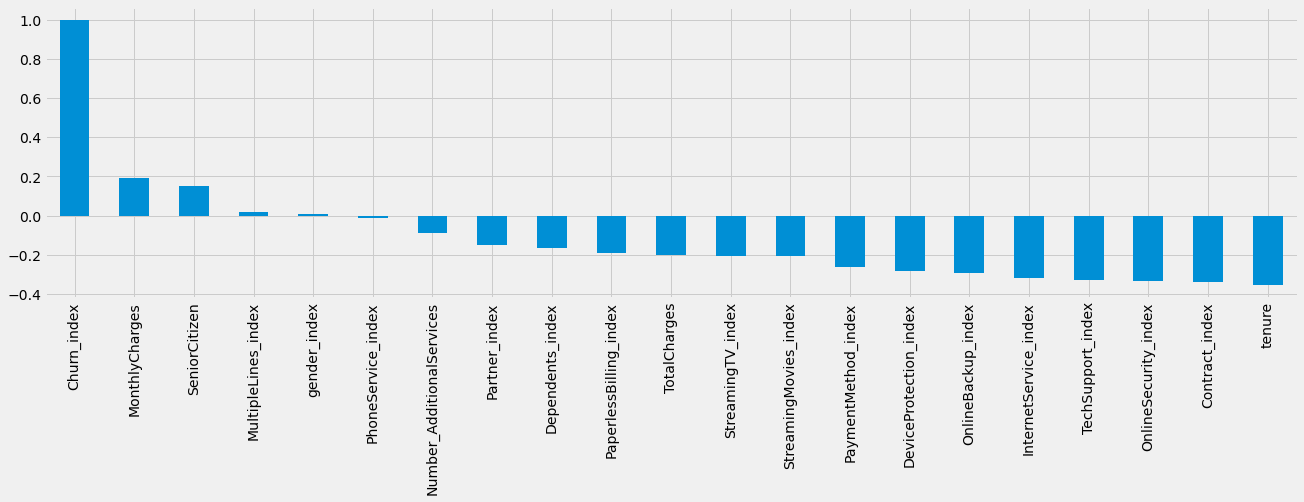

In [75]:
plt.figure(figsize=(16,10))
main_data5_vis.corr()['Churn_index'].sort_values(ascending=False).plot(kind='bar', figsize=(20,5))

In [76]:
main_data5_vis.corr()

,gender_index,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Number_AdditionalServices,OnlineBackup_index,PhoneService_index,OnlineSecurity_index,PaperlessBilling_index,...,Dependents_index,DeviceProtection_index,MultipleLines_index,StreamingTV_index,TechSupport_index,Churn_index,Contract_index,Partner_index,PaymentMethod_index,StreamingMovies_index
gender_index,1.000000,0.001819,-0.005285,0.013779,-0.000048,0.014207,0.002978,-0.007515,0.004365,-0.011902,...,-0.010349,-0.004526,-0.000084,-0.000578,-0.000057,0.008545,-0.005948,0.001379,0.004928,0.001339
SeniorCitizen,0.001819,1.000000,0.015683,0.219874,0.102411,0.067527,-0.152380,-0.008392,-0.210546,-0.156258,...,-0.210550,-0.156700,0.100120,-0.129721,-0.223438,0.150541,-0.108981,0.016957,-0.093712,-0.120658
tenure,-0.005285,0.015683,1.000000,0.246862,0.825880,0.495318,0.180896,-0.007877,0.147575,-0.004823,...,0.163386,0.180895,0.243214,0.138208,0.146727,-0.354049,0.505195,0.381912,0.340939,0.142143
MonthlyCharges,0.013779,0.219874,0.246862,1.000000,0.651065,0.724768,-0.537727,-0.248033,-0.620532,-0.351930,...,-0.112343,-0.512604,0.146127,-0.422060,-0.596805,0.192858,-0.034099,0.097825,-0.074640,-0.423773
TotalCharges,-0.000048,0.102411,0.825880,0.651065,1.000000,0.746101,-0.085017,-0.113008,-0.153234,-0.157830,...,0.064653,-0.077394,0.251357,-0.075697,-0.141011,-0.199484,0.363494,0.319072,0.222694,-0.072571
Number_AdditionalServices,0.014207,0.067527,0.495318,0.724768,0.746101,1.000000,-0.232251,0.091720,-0.274684,-0.182582,...,0.030455,-0.189889,0.300316,-0.186590,-0.234177,-0.087882,0.246700,0.204569,0.129372,-0.182858
OnlineBackup_index,0.002978,-0.152380,0.180896,-0.537727,-0.085017,-0.232251,1.000000,-0.149932,0.751312,0.261565,...,0.160845,0.740244,-0.210051,0.720277,0.753752,-0.291047,0.251612,0.086346,0.183555,0.716388
PhoneService_index,-0.007515,-0.008392,-0.007877,-0.248033,-0.113008,0.091720,-0.149932,1.000000,-0.125544,0.016696,...,0.001078,-0.138938,0.690813,-0.171773,-0.123533,-0.011691,0.000823,-0.018397,0.003106,-0.164379
OnlineSecurity_index,0.004365,-0.210546,0.147575,-0.620532,-0.153234,-0.274684,0.751312,-0.125544,1.000000,0.333656,...,0.188889,0.748684,-0.235077,0.701526,0.790951,-0.332443,0.275385,0.081078,0.214330,0.704672
PaperlessBilling_index,-0.011902,-0.156258,-0.004823,-0.351930,-0.157830,-0.182582,0.261565,0.016696,0.333656,1.000000,...,0.110131,0.275519,-0.108261,0.202967,0.310354,-0.191454,0.130853,0.013957,0.101790,0.211242


<AxesSubplot:>

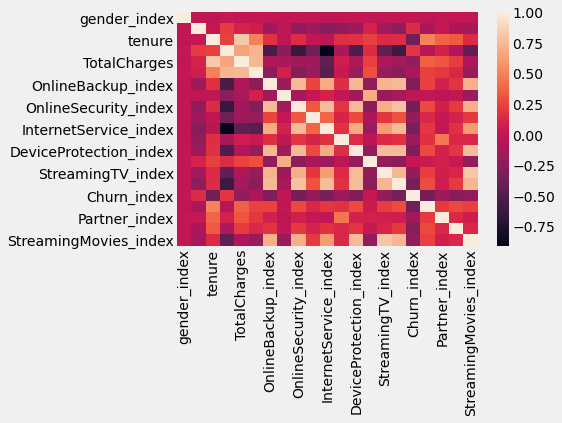

In [77]:
sns.heatmap(main_data5_vis.corr())

#### Train-Test Split 

In [78]:
train, test = main_data5.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 4970
Test Dataset Count: 2062


In [79]:
main_data5.toPandas()

,gender_index,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Number_AdditionalServices,OnlineBackup_index,PhoneService_index,OnlineSecurity_index,PaperlessBilling_index,...,TechSupport_index_encoder,StreamingMovies_index_encoder,Contract_index_encoder,tenure_vec,MonthlyCharges_vec,TotalCharges_vec,tenure_scaled,MonthlyCharges_scaled,TotalCharges_scaled,Features
0,1.0,0,1,29.85,29.85,1,1.0,1.0,0.0,0.0,...,"(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)",[1.0],[29.85],[29.85],[0.0],[0.11542288557213931],[0.0012750980844680362],"(1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, ..."
1,0.0,0,34,56.95,1889.50,2,0.0,0.0,1.0,1.0,...,"(1.0, 0.0)","(1.0, 0.0)","(0.0, 0.0)",[34.0],[56.95],[1889.5],[0.4647887323943662],[0.3850746268656717],[0.21586660512347106],"(0.0, 0.0, 2.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, ..."
2,0.0,0,2,53.85,108.15,2,1.0,0.0,1.0,0.0,...,"(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)",[2.0],[53.85],[108.15],[0.014084507042253521],[0.35422885572139307],[0.010310408492960998],"(0.0, 0.0, 2.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, ..."
3,0.0,0,45,42.30,1840.75,3,0.0,1.0,1.0,1.0,...,"(0.0, 1.0)","(1.0, 0.0)","(0.0, 0.0)",[45.0],[42.3],[1840.75],[0.619718309859155],[0.23930348258706463],[0.21024117239787676],"(0.0, 0.0, 3.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, ..."
4,1.0,0,2,70.70,151.65,0,0.0,0.0,0.0,0.0,...,"(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)",[2.0],[70.7],[151.65],[0.014084507042253521],[0.5218905472636816],[0.015330025386568198],"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7027,0.0,0,24,84.80,1990.50,5,0.0,0.0,1.0,0.0,...,"(0.0, 1.0)","(0.0, 1.0)","(0.0, 0.0)",[24.0],[84.8],[1990.5],[0.323943661971831],[0.6621890547263681],[0.22752134779598432],"(0.0, 0.0, 5.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, ..."
7028,1.0,0,72,103.20,7362.90,4,1.0,0.0,0.0,0.0,...,"(1.0, 0.0)","(0.0, 1.0)","(0.0, 0.0)",[72.0],[103.2],[7362.9],[1.0],[0.8452736318407961],[0.8474613431802446],"(1.0, 0.0, 4.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."
7029,1.0,0,11,29.60,346.45,1,0.0,1.0,1.0,0.0,...,"(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)",[11.0],[29.6],[346.45],[0.14084507042253522],[0.1129353233830846],[0.03780867759058389],"(1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, ..."
7030,0.0,1,4,74.40,306.60,0,0.0,0.0,0.0,0.0,...,"(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)",[4.0],[74.4],[306.6],[0.04225352112676056],[0.5587064676616916],[0.03321024694207247],"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


## Logistic regression

In [80]:
logistic = LogisticRegression(featuresCol = 'Features', labelCol = 'Churn_index')
lr_Model = logistic.fit(train)

C:\Users\vishi\anaconda3\lib\site-packages\pyspark\sql\context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


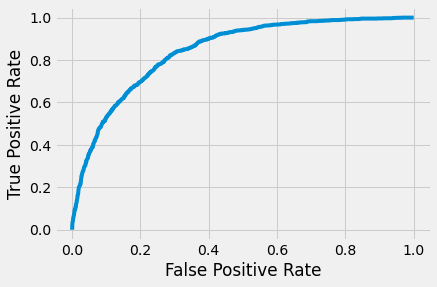

Training set areaUnderROC: 0.8422705375592646


In [81]:
plt.plot(lr_Model.summary.roc.select('FPR').collect(),
         lr_Model.summary.roc.select('TPR').collect())
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()
print('Training set areaUnderROC: ' + str(lr_Model.summary.areaUnderROC))

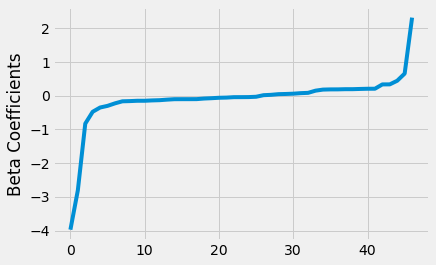

In [82]:
beta = np.sort(lr_Model.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

C:\Users\vishi\anaconda3\lib\site-packages\pyspark\sql\context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


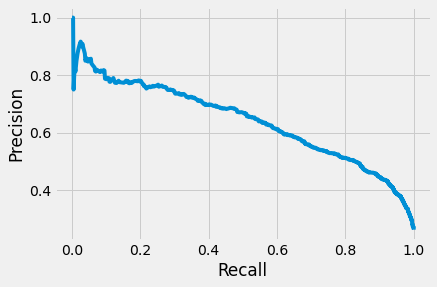

In [83]:
pr = lr_Model.summary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [84]:
pred = lr_Model.transform(test)

In [85]:
evaluator = BinaryClassificationEvaluator().setLabelCol('Churn_index')
print('Test Area Under ROC', str(evaluator.evaluate(pred)))

Test Area Under ROC 0.8625098792919427


In [86]:
evaluator_Multi = MulticlassClassificationEvaluator(labelCol="Churn_index", predictionCol="prediction")

# Make predicitons
prediction_Target = lr_Model.transform(test).select("Churn_index", "prediction")

# Get metrics
acc = evaluator_Multi.evaluate(prediction_Target, {evaluator_Multi.metricName: "accuracy"})
f1 = evaluator_Multi.evaluate(prediction_Target, {evaluator_Multi.metricName: "f1"})
weighted_Precision = evaluator_Multi.evaluate(prediction_Target, {evaluator_Multi.metricName: "weightedPrecision"})
weighted_Recall = evaluator_Multi.evaluate(prediction_Target, {evaluator_Multi.metricName: "weightedRecall"})

In [87]:
acc

0.8205625606207565

In [88]:
f1

0.8127292536536753

In [89]:
weighted_Precision

0.8127957471846126

In [90]:
weighted_Recall

0.8205625606207565

## optimized logistic regression

In [91]:
# Create the parameter grid
grid = tune.ParamGridBuilder()

# Add the hyperparameter
grid = grid.addGrid(logistic.regParam, np.arange(0.01, 0.5, 2.0))
grid = grid.addGrid(logistic.elasticNetParam, [0,0.5, 1])
grid = grid.addGrid(logistic.maxIter,[1,5,10])
# Build the grid
grid = grid.build()

In [92]:
cv = tune.CrossValidator(estimator=logistic, estimatorParamMaps=grid, evaluator=evaluator,numFolds=5)

In [93]:
best_lr = cv.fit(train)
print(best_lr)

CrossValidatorModel_4df433d6083e


In [94]:
test_results = best_lr.transform(test)

# Evaluate the predictions
print(evaluator.evaluate(test_results))

0.8606554754679594


## Decision tree

In [95]:
decision_tree = DecisionTreeClassifier(featuresCol = 'Features', labelCol = 'Churn_index', maxDepth = 3)
decision_tree_model = decision_tree.fit(train)

In [96]:
pred1 = decision_tree_model.transform(test)

In [97]:
print("Test Area Under ROC: " + str(evaluator.evaluate(pred1, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.7731939706399884


In [98]:
acc_1 = evaluator_Multi.evaluate(pred1, {evaluator_Multi.metricName: "accuracy"})
f1_1 = evaluator_Multi.evaluate(pred1, {evaluator_Multi.metricName: "f1"})
weighted_Precision1 = evaluator_Multi.evaluate(pred1, {evaluator_Multi.metricName: "weightedPrecision"})
weighted_Recall1 = evaluator_Multi.evaluate(pred1, {evaluator_Multi.metricName: "weightedRecall"})

In [99]:
acc_1

0.7851600387972842

In [100]:
f1_1

0.7572280237053672

In [101]:
weighted_Precision1

0.7746626115238644

In [102]:
weighted_Recall1

0.7851600387972841

## Random Forest Classifier


In [103]:
random_forest = RandomForestClassifier(featuresCol = 'Features', labelCol = 'Churn_index')
random_forest_Model = random_forest.fit(train)
pred2 = random_forest_Model.transform(test)

In [104]:
print("Test Area Under ROC: " + str(evaluator.evaluate(pred2, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.8562783714898146


In [105]:
acc_2 = evaluator_Multi.evaluate(pred2, {evaluator_Multi.metricName: "accuracy"})
print(acc_2)
print("##########################")
f1_2 = evaluator_Multi.evaluate(pred2, {evaluator_Multi.metricName: "f1"})
print(f1_2)
print("##########################")
weighted_Precision_2 = evaluator_Multi.evaluate(pred2, {evaluator_Multi.metricName: "weightedPrecision"})
print(weighted_Precision_2)
print("##########################")
weighted_Recall_2 = evaluator_Multi.evaluate(pred2, {evaluator_Multi.metricName: "weightedRecall"})
print(weighted_Recall_2)
print("##########################")

0.7904946653734238
##########################
0.7619776471792821
##########################
0.7835832864325184
##########################
0.7904946653734238
##########################


## Gradient-Boosted Tree Classifier

In [106]:
gbt = GBTClassifier(featuresCol = 'Features', labelCol = 'Churn_index',maxIter=10)
gbtModel = gbt.fit(train)
pred4 = gbtModel.transform(test)

In [107]:
print("Test Area Under ROC: " + str(evaluator.evaluate(pred4, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.8547829992049167


In [108]:
acc_3 = evaluator_Multi.evaluate(pred4, {evaluator_Multi.metricName: "accuracy"})
print(acc_3)
print("##########################")
f1_3 = evaluator_Multi.evaluate(pred4, {evaluator_Multi.metricName: "f1"})
print(f1_3)
print("##########################")
weighted_Precision_3 = evaluator_Multi.evaluate(pred4, {evaluator_Multi.metricName: "weightedPrecision"})
print(weighted_Precision_3)
print("##########################")
weighted_Recall_3 = evaluator_Multi.evaluate(pred4, {evaluator_Multi.metricName: "weightedRecall"})
print(weighted_Recall_3)
print("##########################")

0.8108632395732299
##########################
0.8014928358075366
##########################
0.8017426984105838
##########################
0.8108632395732299
##########################


In [109]:
paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [2, 4, 6])
             .addGrid(gbt.maxBins, [20, 60])
             .addGrid(gbt.maxIter, [10, 20])
             .build())
cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)
# Run cross validations.  This can take about 6 minutes since it is training over 20 trees!
cvModel = cv.fit(train)
predictions = cvModel.transform(test)
evaluator.evaluate(predictions)

0.8592697085208962

In [110]:
spark.stop()

In [111]:
from prettytable import PrettyTable 

In [114]:
x = PrettyTable()

x.field_names = ["Model Name", "Area under roc", "accuracy", "F1 score", "weighted Precision","weighted recall"]

x.add_row(["logistic regression",0.8625,0.8205,0.8127,0.8127,0.8205])
x.add_row(["Decision tree", 0.7731,0.7851,0.7572,0.7746,0.7851])
x.add_row(["Random Forest Classifier", 0.8573,0.7870,0.7591,0.7777,0.7870])
x.add_row(["Gradient-Boosted Tree Classifier", 0.8547,0.8108,0.8014,0.8017,0.8108])

print(x)

+----------------------------------+----------------+----------+----------+--------------------+-----------------+
|            Model Name            | Area under roc | accuracy | F1 score | weighted Precision | weighted recall |
+----------------------------------+----------------+----------+----------+--------------------+-----------------+
|       logistic regression        |     0.8625     |  0.8205  |  0.8127  |       0.8127       |      0.8205     |
|          Decision tree           |     0.7731     |  0.7851  |  0.7572  |       0.7746       |      0.7851     |
|     Random Forest Classifier     |     0.8573     |  0.787   |  0.7591  |       0.7777       |      0.787      |
| Gradient-Boosted Tree Classifier |     0.8547     |  0.8108  |  0.8014  |       0.8017       |      0.8108     |
+----------------------------------+----------------+----------+----------+--------------------+-----------------+
